Plot grid: H=12, W=18 (methods=16 + 2)
Saved figures to ./figures/


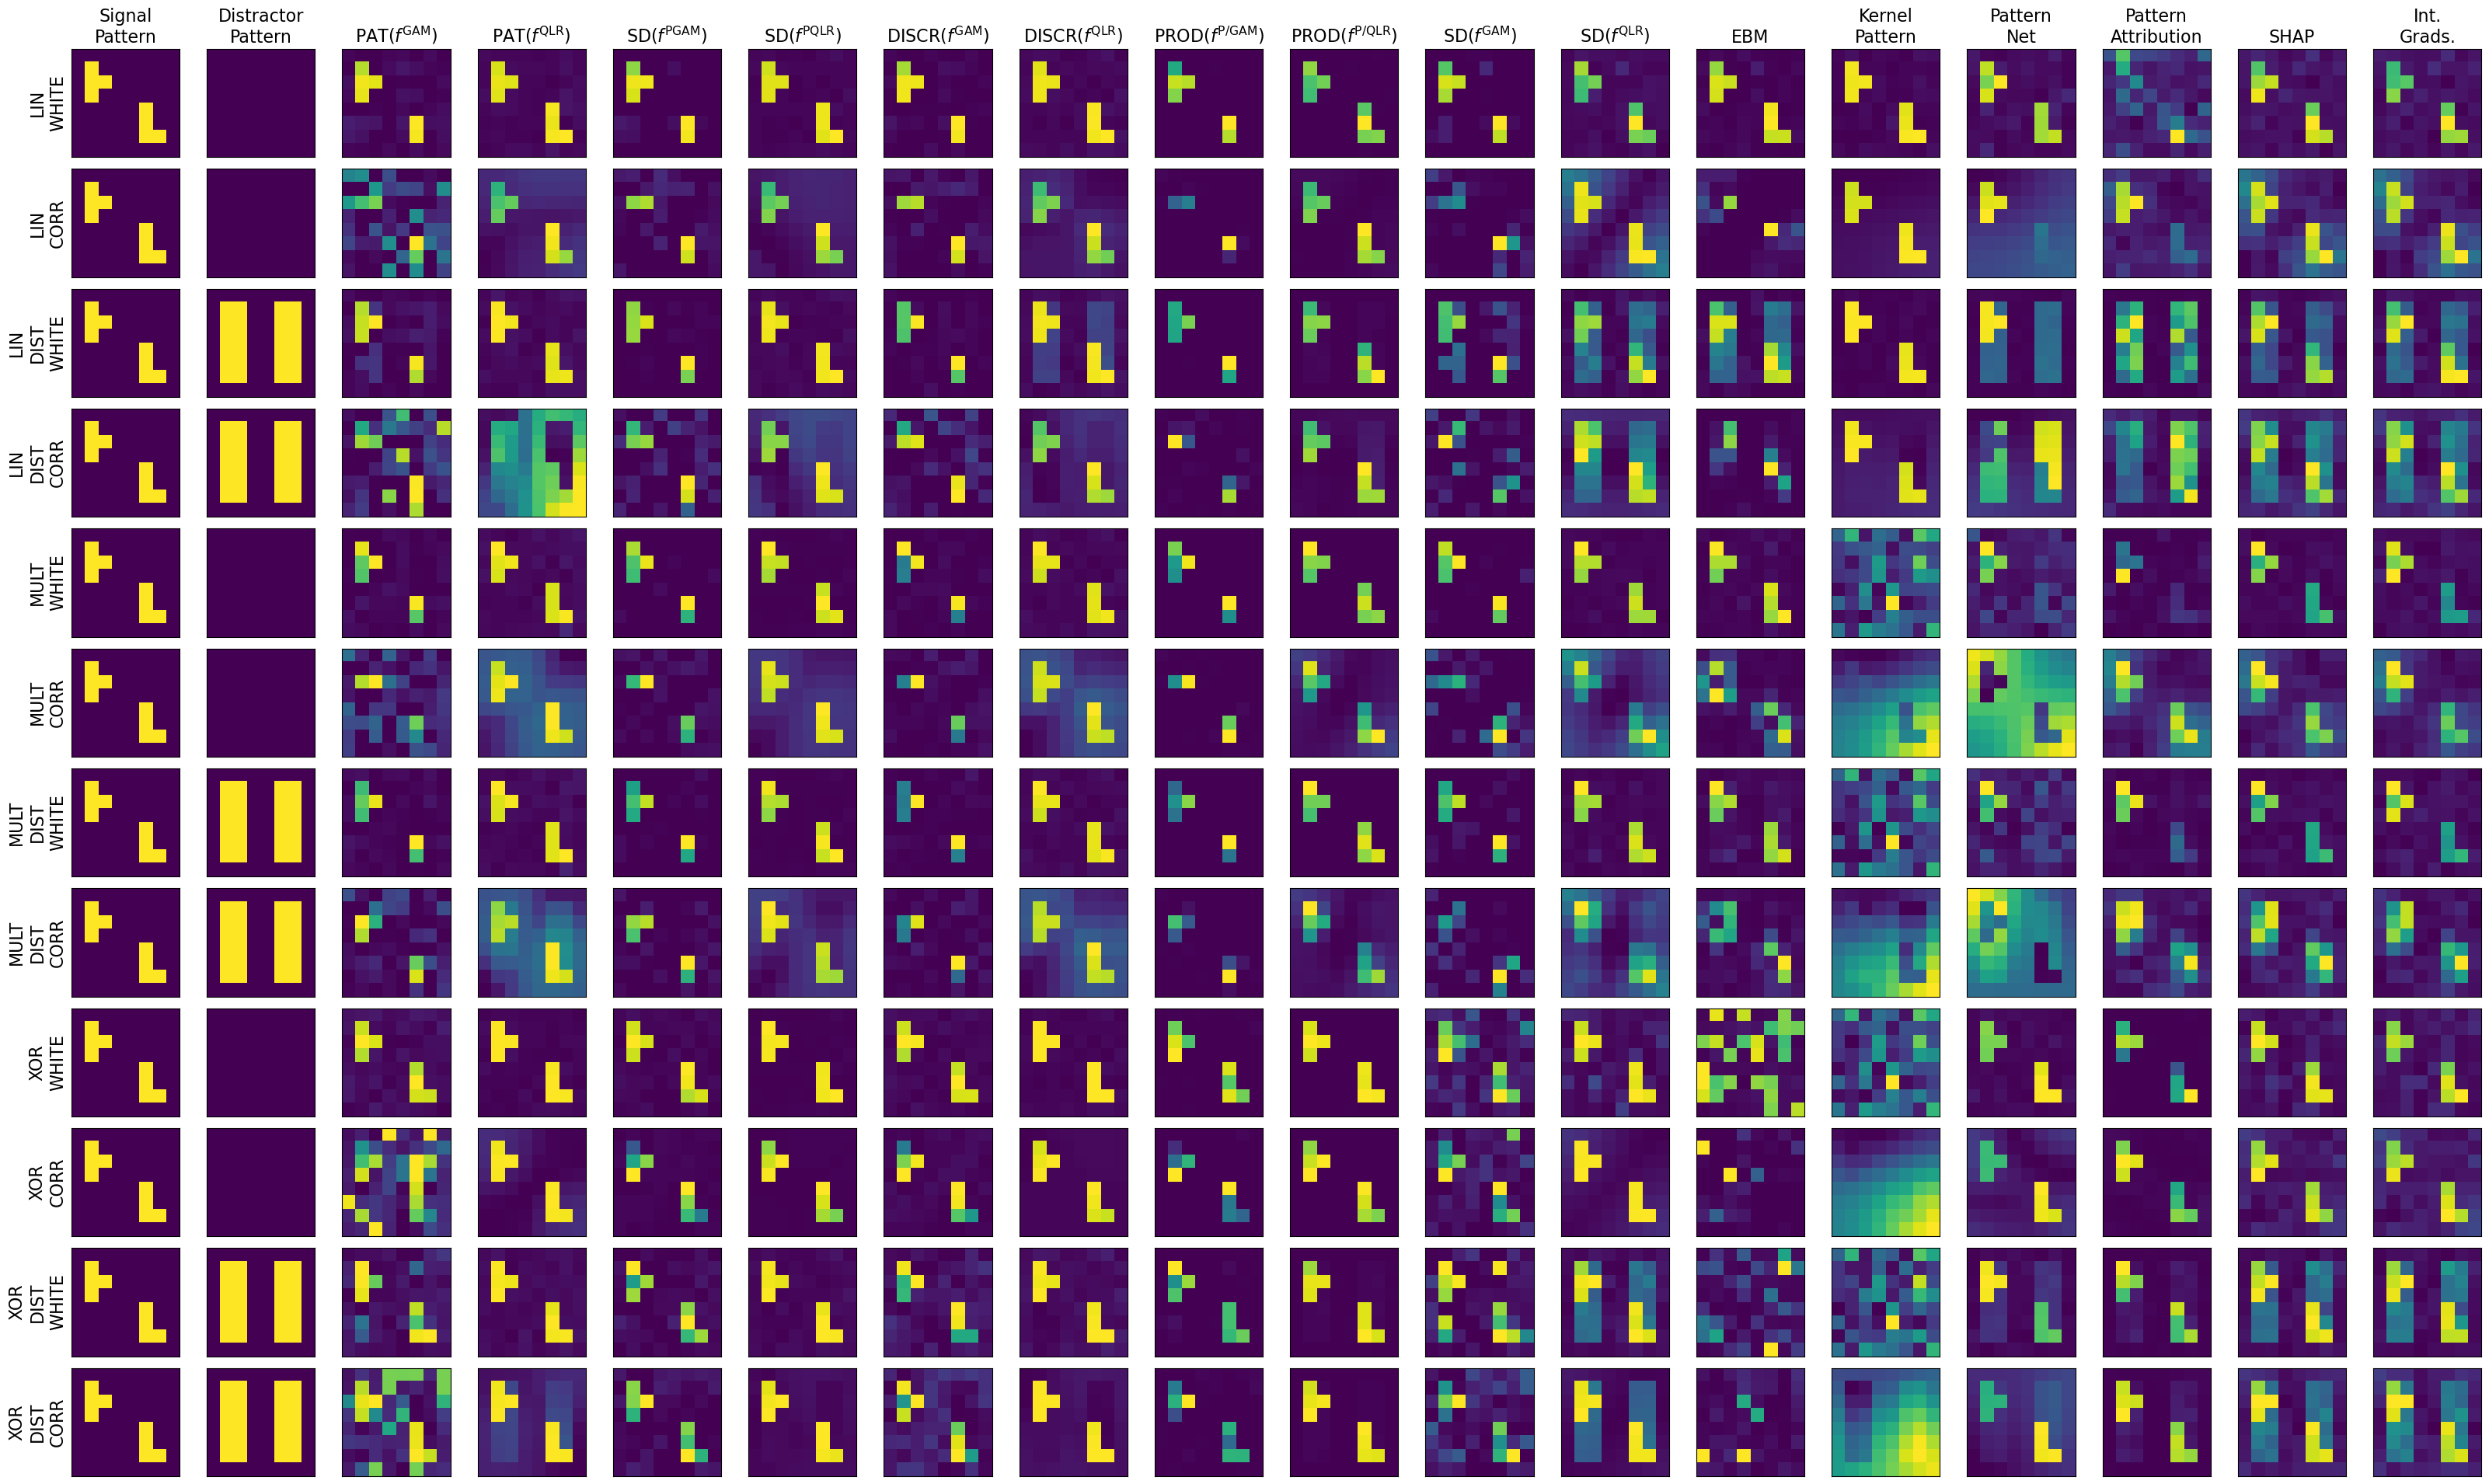

In [21]:
import os
import numpy as np
import pickle as pkl
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- FAST (for NAM 192→64 mapping needs the learned pairs) ---
from interpret.utils import measure_interactions
def FAST(X_train, y_train, n_interactions, init_score=None, feature_names=None, feature_types=None):
    interactions = measure_interactions(
        X_train, y_train, interactions=n_interactions,
        init_score=init_score, feature_names=feature_names, feature_types=feature_types
    )
    pairs = []
    for (i, j), _ in interactions:
        pairs.append((i, j))
    return pairs, None

# --- IO ---
SEEDS = [2025, 1283123, 3043040, 8238238, 123123]
seed_idx = 0  # which seed to visualise
D_MAIN_FEATURES = 64

with open('./models/xai_tris/explanations.pkl', "rb") as f:
    explanations = pkl.load(f)

# --- Helpers for scenario data (to get FAST pairs when needed) ---
def load_xor_training(scenario_full_name: str):
    path = f'./data/xai_tris/{scenario_full_name}.pkl'
    if not os.path.exists(path): return None, None
    try:
        data = pkl.load(open(path, "rb"))
        return data.x_train.float(), data.y_train
    except Exception:
        return None, None

# --- Your “max-abs signed” reducers (as provided) ---
def transform_nam_interaction_max_signed(pattern, interaction_pairs=(), d=64):
    pattern = np.asarray(pattern)
    m = len(interaction_pairs)
    if d + m != pattern.size or d <= 0:
        raise ValueError("Length mismatch: expected len(pattern) == d + len(interaction_pairs).")
    main = pattern[:d].astype(float)
    inter = pattern[d:].astype(float) if m > 0 else np.empty(0, dtype=float)
    adj = [[] for _ in range(d)]
    for k, (i, j) in enumerate(interaction_pairs):
        if 0 <= i < d and 0 <= j < d:
            adj[i].append(k); adj[j].append(k)
    out = np.empty(d, dtype=float)
    for i in range(d):
        best_val = float(main[i]); best_abs = abs(best_val)
        for k in adj[i]:
            v = float(inter[k]); av = abs(v)
            if av > best_abs: best_val, best_abs = v, av
        out[i] = best_val
    return out

def qlr_2144_to_64_signed_max(expl_2144: np.ndarray):
    if expl_2144 is None or expl_2144.size != 2144:
        return np.full(64, np.nan, dtype=float)
    d = 64
    linear = expl_2144[:d].astype(float)
    inter_block = expl_2144[d:].astype(float)  # length 2080
    i0, i1 = np.triu_indices(d, 0)
    inter_indices_per_feat = [[] for _ in range(d)]
    for idx, (a, b) in enumerate(zip(i0, i1)):
        inter_indices_per_feat[a].append(idx)
        if a != b:
            inter_indices_per_feat[b].append(idx)
    out = np.empty(d, dtype=float)
    for i in range(d):
        best_val = float(linear[i]); best_abs = abs(best_val)
        for idx in inter_indices_per_feat[i]:
            v = float(inter_block[idx]); av = abs(v)
            if av > best_abs: best_val, best_abs = v, av
        out[i] = best_val
    return out

def nam_192_to_64_signed_max(expl_192: np.ndarray, scenario_key: str):
    if expl_192 is None or expl_192.size != 192:
        return np.full(64, np.nan, dtype=float)
    interaction_pairs = []
    if 'xor' in scenario_key.lower():
        Xtr, ytr = load_xor_training(scenario_key)
        if Xtr is not None and ytr is not None:
            try:
                interaction_pairs, _ = FAST(Xtr, ytr, n_interactions=128)
            except Exception:
                interaction_pairs = []
    try:
        if len(interaction_pairs) == 128:
            return transform_nam_interaction_max_signed(expl_192, interaction_pairs=interaction_pairs, d=64)
        else:
            return expl_192[:64].astype(float)  # fallback: main effects only
    except Exception:
        return expl_192[:64].astype(float)

# Reduce arbitrary payload to (64,) using the above rules
def reduce_to_vector_per_seed(obj):
    if obj is None: return None
    if isinstance(obj, (list, tuple)):
        if len(obj) == 0: return None
        if all(np.isscalar(x) or (isinstance(x, np.generic) and np.ndim(x) == 0) for x in obj):
            return np.asarray(obj, dtype=float)
        arrs = [np.asarray(x) for x in obj]
        arrs = [a.squeeze(-1) if (a.ndim == 2 and a.shape[-1] == 1) else a for a in arrs]
        if all(a.ndim == 1 for a in arrs):
            return np.mean(np.stack(arrs, 0), 0).astype(float)
        stacked = np.array([np.ravel(a) for a in arrs], dtype=float)
        return np.mean(stacked, 0) if stacked.ndim == 2 else np.ravel(stacked).astype(float)
    arr = np.asarray(obj)
    if arr.ndim == 1: return arr.astype(float)
    if arr.ndim == 2:
        if arr.shape[1] == 64: return np.mean(arr, 0).astype(float)
        if arr.shape[1] == 1:  return arr[:, 0].astype(float)
        if arr.shape[0] == 1:  return arr[0, :].astype(float)
        return np.ravel(arr).astype(float)
    if arr.ndim == 3 and arr.shape[1] == 64 and arr.shape[2] == 1:
        return np.mean(arr[:, :, 0], 0).astype(float)
    return np.ravel(arr).astype(float)

def normalize_to_64(expl_raw, method: str, scenario_key: str):
    v = reduce_to_vector_per_seed(expl_raw)
    if v is None: return np.full(64, np.nan, dtype=float)
    n = v.size
    if n == 64:   return v.astype(float)
    if n == 192:  return nam_192_to_64_signed_max(v, scenario_key)
    if n == 2144 and method == 'pattern_qlr':
        return qlr_2144_to_64_signed_max(v)
    return np.full(64, np.nan, dtype=float)

# --- Local-explanation → global (64,) via mean |·| ---
def transform_local_explanations(explanation_array, expected_dim=64):
    arr = np.array(explanation_array)
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = np.squeeze(arr, -1)
    if arr.ndim != 2 or arr.shape[1] != expected_dim:
        raise ValueError(f"Unexpected local explanation shape {arr.shape} (want (N,{expected_dim}))")
    return np.mean(np.abs(arr), axis=0)

# -------------------------
# Build transformed maps
# -------------------------
transformed_results = {}

LOCAL_METHODS = {'shap', 'ig', 'pattern_net', 'pattern_attribution'}
NAM_QLR_METRIC_KEYS = {
    'SD_NAM', 'SDb_NAM', 'DISCR_NAM', 'w_NAM', 'b_uni_NAM', 'd_uni_NAM',
    'SD_QLR', 'SDb_QLR', 'DISCR_QLR', 'w_QLR', 'b_uni_QLR', 'd_uni_QLR'
}

def get_payload_for_seed(per_seed_list, seed_idx):
    """Return payload for given seed_idx; fallback to 0 if out of range; None if list empty/invalid."""
    if not isinstance(per_seed_list, list) or len(per_seed_list) == 0:
        return None
    idx = seed_idx if (0 <= seed_idx < len(per_seed_list)) else 0
    return per_seed_list[idx]

for scenario_name, scenario_data in explanations.items():
    out = {}
    for method_name, per_seed_list in scenario_data.items():
        payload = get_payload_for_seed(per_seed_list, seed_idx)
        if payload is None:
            continue

        try:
            if method_name in LOCAL_METHODS:
                vec64 = transform_local_explanations(payload, D_MAIN_FEATURES)

            elif method_name in {'pattern_gam', 'ebm'}:
                vec64 = normalize_to_64(payload, method=method_name, scenario_key=scenario_name)

            elif method_name == 'pattern_qlr':
                vec64 = normalize_to_64(payload, method='pattern_qlr', scenario_key=scenario_name)

            elif method_name == 'kernel_svm':
                arr = np.asarray(payload)
                if arr.shape != (D_MAIN_FEATURES,):
                    # allow squeeze fallback
                    arr = np.ravel(arr).astype(float)
                    if arr.size != D_MAIN_FEATURES:
                        continue
                vec64 = np.abs(arr).astype(float)

            elif method_name in NAM_QLR_METRIC_KEYS:
                raw_vec = np.asarray(payload, dtype=float)
                if method_name.endswith('_NAM'):
                    if raw_vec.size == 64:
                        vec64 = raw_vec
                    elif raw_vec.size == 192:
                        vec64 = nam_192_to_64_signed_max(raw_vec, scenario_key=scenario_name)
                    else:
                        vec64 = raw_vec[:64]
                elif method_name.endswith('_QLR'):
                    if raw_vec.size == 64:
                        vec64 = raw_vec
                    elif raw_vec.size == 2144:
                        vec64 = qlr_2144_to_64_signed_max(raw_vec)
                    else:
                        vec64 = raw_vec[:64]
                else:
                    continue
            else:
                continue  # unknown method key

            if vec64 is None or np.asarray(vec64).size != 64:
                continue
            out[method_name] = np.asarray(vec64, dtype=float)

        except Exception:
            # Ignore any method failing shape/processing for this scenario
            continue

    # Derive PROD_* if both SD_* and SDb_* present
    if 'SD_NAM' in out and 'SDb_NAM' in out:
        out['PROD_NAM'] = np.asarray(out['SD_NAM'], float) * np.asarray(out['SDb_NAM'], float)
    if 'SD_QLR' in out and 'SDb_QLR' in out:
        out['PROD_QLR'] = np.asarray(out['SD_QLR'], float) * np.asarray(out['SDb_QLR'], float)

    if len(out) > 0:
        transformed_results[scenario_name] = out

# -------------------------
# Plotting
# -------------------------
import matplotlib.pyplot as plt

def get_scenario_sort_key(scenario_name_str):
    s = scenario_name_str.lower()
    t = 99
    if "linear" in s: t = 0
    elif "multiplicative" in s: t = 1
    elif "xor" in s: t = 2
    dist = 0 if "distractor" not in s else 1
    bg = 0 if "white" in s else (1 if "correlated" in s else 99)
    return (t, dist, bg, scenario_name_str)

def parse_scenario_name_for_plot(s):
    s = s.lower(); parts = []
    if "linear" in s: parts.append("LIN")
    elif "multiplicative" in s: parts.append("MULT")
    elif "xor" in s: parts.append("XOR")
    if "distractor" in s: parts.append("DIST")
    if "white" in s: parts.append("WHITE")
    elif "correlated" in s: parts.append("CORR")
    return " ".join(parts)

METHOD_PARSER = {
    'pattern_gam': r'$\text{PAT}(f^\text{GAM})$',
    'pattern_qlr': r'$\text{PAT}(f^\text{QLR})$',
    'SD_NAM': r'$\text{SD}(f^\text{GAM})$',
    'SDb_NAM': r'$\text{SD}(f^\text{PGAM})$',
    'PROD_NAM': r'$\text{PROD}(f^\text{P/GAM})$',
    'DISCR_NAM': r'$\text{DISCR}(f^\text{GAM})$',
    'SD_QLR': r'$\text{SD}(f^\text{QLR})$',
    'SDb_QLR': r'$\text{SD}(f^\text{PQLR})$',
    'PROD_QLR': r'$\text{PROD}(f^\text{P/QLR})$',
    'DISCR_QLR': r'$\text{DISCR}(f^\text{QLR})$',
    'kernel_svm': 'Kernel\nPattern',
    'ebm': 'EBM',
    'shap': 'SHAP',
    'ig': 'Int.\nGrads.',
    'nam': 'NAM',
    'pattern_net': 'Pattern\nNet',
    'pattern_attribution': 'Pattern\nAttribution'
}

PREFERRED_METHOD_ORDER = [
    'pattern_gam', 'pattern_qlr',
    'SDb_NAM',      'SDb_QLR', 
    'DISCR_NAM', 'DISCR_QLR', 
    'PROD_NAM', 'PROD_QLR', 
    'SD_NAM', 'SD_QLR', 
    'ebm', 'kernel_svm', 'pattern_net', 'pattern_attribution', 'shap', 'ig', 'nam'
]

# ---- Filtering: set dataset_ind to None to keep all scenarios
dataset_ind = 0  # or None to disable filtering
def scenario_passes_filter(name: str) -> bool:
    if 'translations' in name.lower():
        return False
    if dataset_ind is None:
        return True
    # Relaxed match: accept either "..._white_1" or "..._correlated_1" anywhere
    s = name.lower()
    return (f'_white_{dataset_ind}' in s) or (f'_correlated_{dataset_ind}' in s)

# Candidate scenarios that actually have at least one method
candidate_keys = [k for k, v in transformed_results.items() if len(v) > 0]
sorted_keys = sorted([k for k in candidate_keys if scenario_passes_filter(k)], key=get_scenario_sort_key)

# Determine union of methods that actually appear across the chosen scenarios
all_methods = set()
for k in sorted_keys:
    all_methods.update(transformed_results[k].keys())

# Exclude non-plot keys (weights / intercepts)
EXCLUDED_PLOT_KEYS = {
    'w_NAM', 'b_uni_NAM', 'd_uni_NAM',
    'w_QLR', 'b_uni_QLR', 'd_uni_QLR'
}
all_methods -= EXCLUDED_PLOT_KEYS


ordered_methods = [m for m in PREFERRED_METHOD_ORDER if m in all_methods]
ordered_methods += [m for m in sorted(all_methods) if m not in ordered_methods]

# Diagnostics & guards
if len(sorted_keys) == 0:
    available = sorted(candidate_keys)
    raise ValueError(
        "No scenarios selected for plotting (H==0). "
        "Check your filename patterns and dataset_ind.\n"
        f"Available scenarios with data: {available}\n"
        f"Set dataset_ind=None to disable filtering."
    )

if len(ordered_methods) == 0:
    # show per-scenario methods to help debugging
    per_sc = {k: sorted(list(transformed_results[k].keys())) for k in sorted_keys}
    raise ValueError(
        "No methods available for selected scenarios (W==2). "
        "Inspect per-scenario methods below.\n"
        f"{per_sc}"
    )

# Plot
W = len(ordered_methods) + 2
H = len(sorted_keys)
print(f"Plot grid: H={H}, W={W} (methods={len(ordered_methods)} + 2)")

fig, axs = plt.subplots(H, W, figsize=(1.8*W, 1.6*H))
axs[0,0].set_title('Signal\nPattern', fontsize=16)
axs[0,1].set_title('Distractor\nPattern', fontsize=16)

for i, sc in enumerate(sorted_keys):
    res = transformed_results[sc]
    axs[i,0].imshow(combined_mask, vmin=0, vmax=np.max(combined_mask))
    if 'dist' in sc.lower():
        axs[i,1].imshow(distractor_mask, vmin=0, vmax=np.max(distractor_mask))
    else:
        axs[i,1].imshow(np.zeros((8,8)), vmin=0, vmax=1.0)
    for j in (0,1):
        axs[i,j].set_xticks([]); axs[i,j].set_yticks([])
    axs[i,0].set_ylabel(parse_scenario_name_for_plot(sc).replace(' ', '\n'), fontsize=16)

    for col, m in enumerate(ordered_methods, start=2):
        if i == 0:
            axs[0,col].set_title(METHOD_PARSER.get(m, m.replace('_','\n')), fontsize=16)
        vec = res.get(m, None)
        img = np.zeros((8,8)) if vec is None else np.array(vec).reshape(8,8)
        axs[i,col].imshow(np.abs(img))
        axs[i,col].set_xticks([]); axs[i,col].set_yticks([])

plt.tight_layout()
os.makedirs('./figures', exist_ok=True)
plt.savefig(f'./figures/xai_tris_qualitative_{seed_idx}.png', bbox_inches='tight')
plt.savefig(f'./figures/xai_tris_qualitative_{seed_idx}_hires.png', dpi=300, bbox_inches='tight')
print("Saved figures to ./figures/")

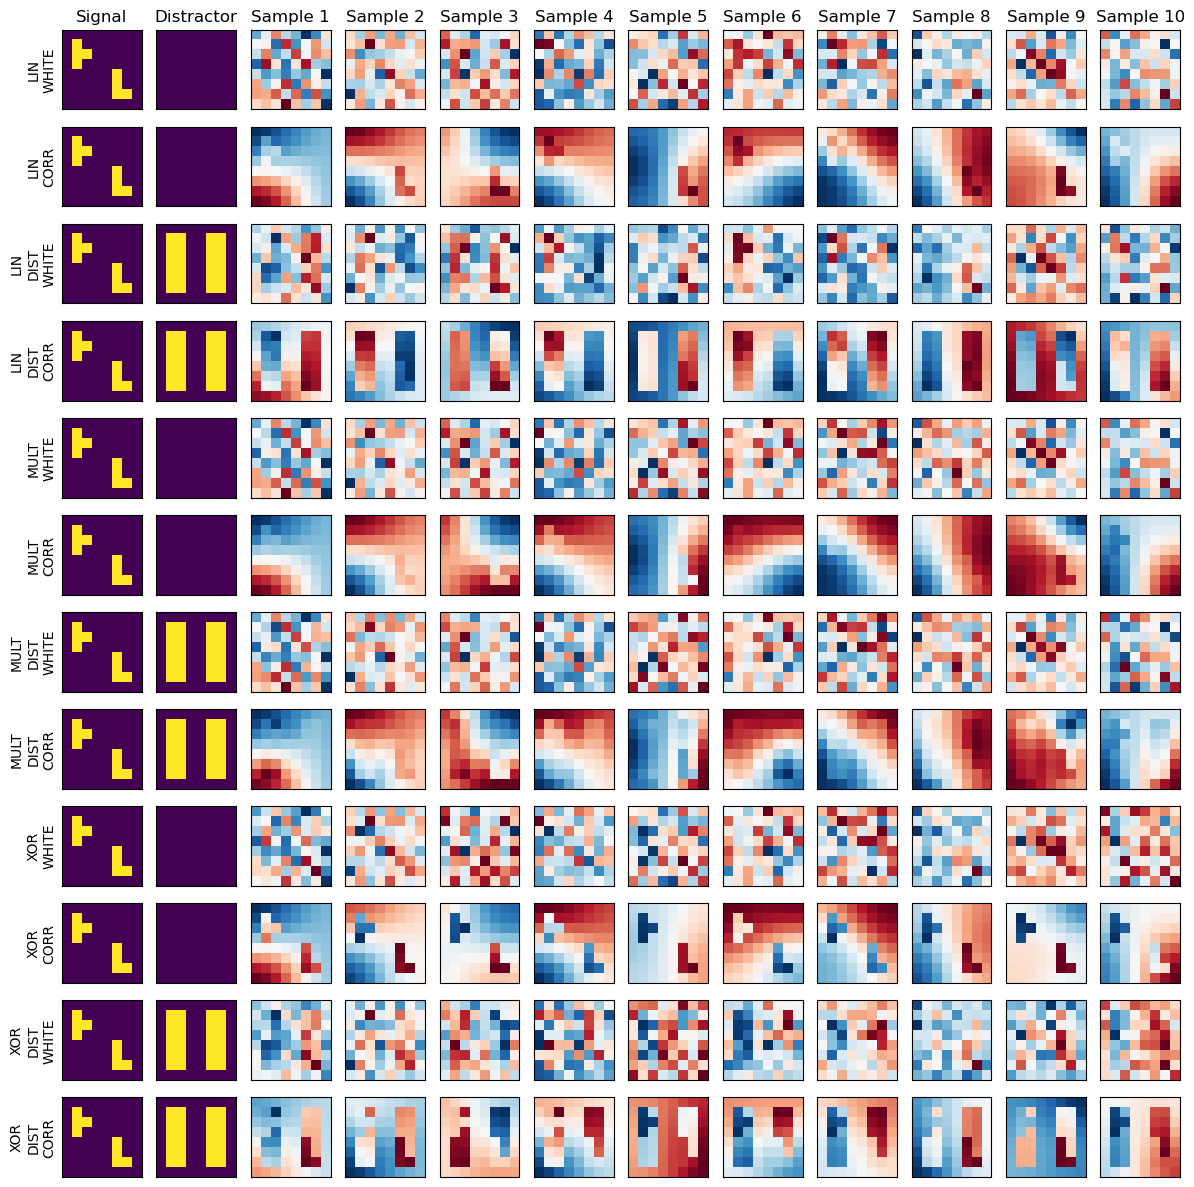

In [27]:
import os
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

# Constants
DATA_DIR = './data/old_xai_tris'
N_SAMPLES = 10
DATASET_IND = 0  # use index to match files like *_0.pkl

# Scenario parsing utilities
def get_scenario_sort_key(scenario_name_str):
    name_lower = scenario_name_str.lower()
    type_order = {'linear': 0, 'multiplicative': 1, 'xor': 2}
    background_order = {'white': 0, 'correlated': 1}
    dist_order = 1 if "distractor" in name_lower else 0
    scenario_type = next((k for k in type_order if k in name_lower), '')
    background = next((k for k in background_order if k in name_lower), '')
    return (type_order.get(scenario_type, 99), dist_order, background_order.get(background, 99), scenario_name_str)

def parse_scenario_name_for_plot(s):
    parts = []
    if 'linear' in s: parts.append('LIN')
    elif 'multiplicative' in s: parts.append('MULT')
    elif 'xor' in s: parts.append('XOR')
    if 'distractor' in s: parts.append('DIST')
    if 'white' in s: parts.append('WHITE')
    elif 'correlated' in s: parts.append('CORR')
    return ' '.join(parts)

# Masks for visual reference
normal_t = [[1,0],[1,1],[1,0]]
normal_l = [[1,0],[1,0],[1,1]]
combined_mask = np.zeros((8,8))
combined_mask[1:4, 1:3] = normal_t
combined_mask[4:7, 5:7] = normal_l
combined_mask = combined_mask.reshape((8,8))

distractor_sq = [[1,1],[1,1],[1,1]]
distractor_mask = np.zeros((8,8))
distractor_mask[1:4, 1:3] = distractor_sq
distractor_mask[1:4, 5:7] = distractor_sq
distractor_mask[4:7, 1:3] = distractor_sq
distractor_mask[4:7, 5:7] = distractor_sq
distractor_mask = distractor_mask.reshape((8,8))

# Load data files
file_paths = sorted(set(glob.glob('./data/xai_tris/*_0.pkl')) - set(glob.glob('./data/xai_tris/*translations*_0.pkl')), key=get_scenario_sort_key)

# Plot grid: rows = scenarios, columns = [signal, distractor, 10 samples]
fig, axs = plt.subplots(len(file_paths), 2 + N_SAMPLES, figsize=(2+N_SAMPLES, len(file_paths)))

for row_idx, file_path in enumerate(file_paths):
    scenario_name = os.path.basename(file_path).replace('.pkl', '')
    
    # Load x_test
    with open(file_path, 'rb') as f:
        record = pkl.load(f)
        x_samples = record.x_test[:N_SAMPLES]  # shape (N_SAMPLES, 64)

    # Signal pattern
    axs[row_idx, 0].imshow(combined_mask)
    axs[row_idx, 0].set_title("Signal" if row_idx == 0 else "")
    axs[row_idx, 0].set_xticks([])
    axs[row_idx, 0].set_yticks([])

    # Distractor pattern
    if 'distractor' in scenario_name:
        axs[row_idx, 1].imshow(distractor_mask)
    else:
        axs[row_idx, 1].imshow(np.zeros((8,8)))
    axs[row_idx, 1].set_title("Distractor" if row_idx == 0 else "")
    axs[row_idx, 1].set_xticks([])
    axs[row_idx, 1].set_yticks([])

    # Raw input samples
    for col_idx, x in enumerate(x_samples):
        axs[row_idx, col_idx + 2].imshow(x.reshape(8, 8), cmap='RdBu_r')
        axs[row_idx, col_idx + 2].set_xticks([])
        axs[row_idx, col_idx + 2].set_yticks([])
        if row_idx == 0:
            axs[row_idx, col_idx + 2].set_title(f"Sample {col_idx+1}")

    # Row label
    axs[row_idx, 0].set_ylabel(parse_scenario_name_for_plot(scenario_name).replace(" ", "\n"))

plt.tight_layout()
plt.savefig('./figures/xai_tris_data.png', bbox_inches='tight')
plt.savefig('./figures/xai_tris_data_hires.png', dpi=300, bbox_inches='tight')
plt.show()


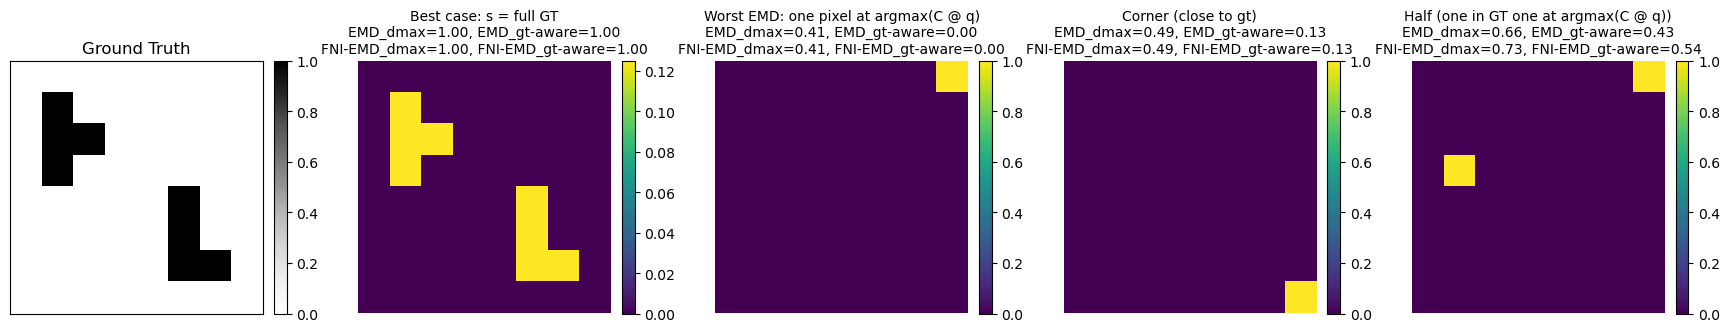

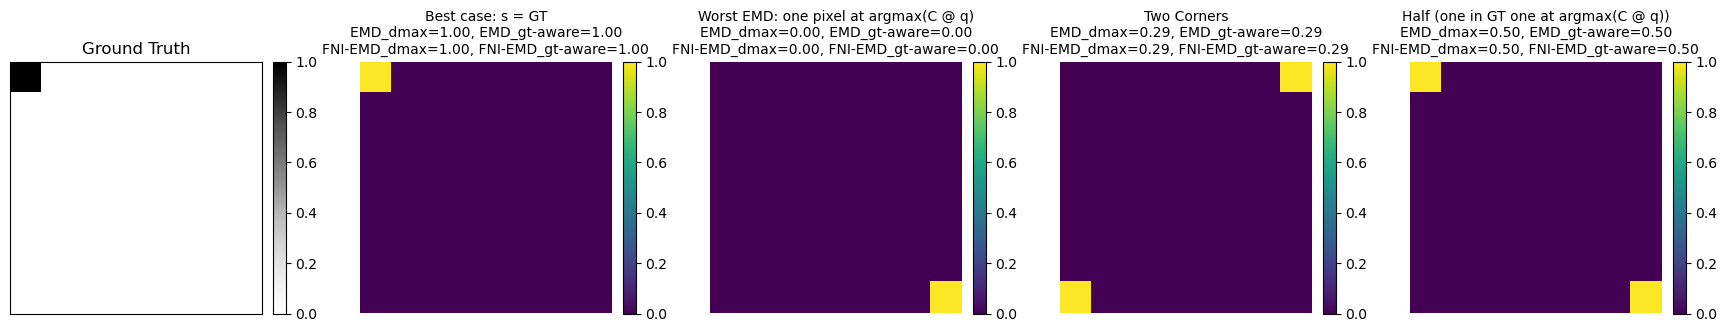

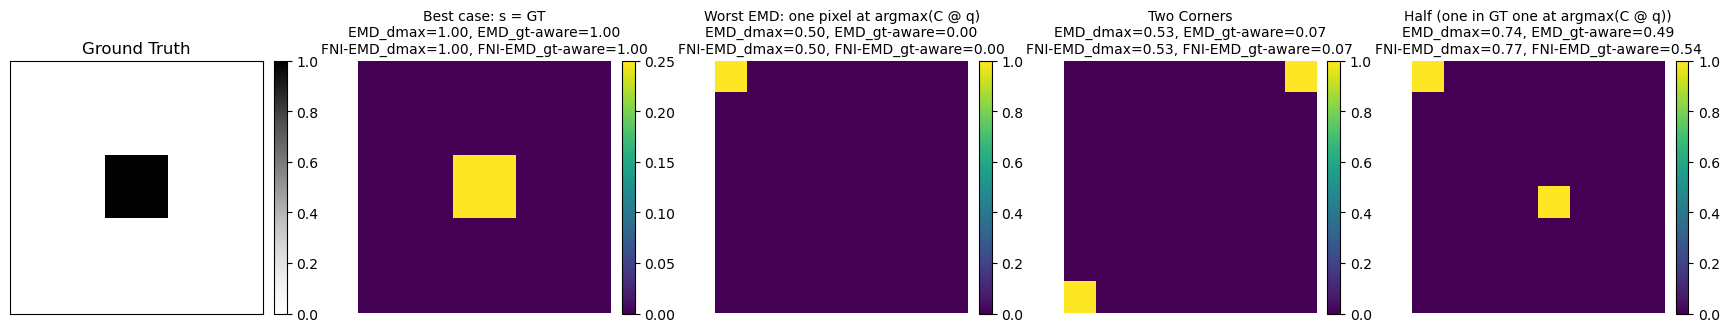

In [46]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ot.lp import emd  # pip install POT

# -----------------------
# Cost / metric utilities
# -----------------------
def create_cost_matrix(edge):
    rr, cc = np.indices((edge, edge))
    coords = np.column_stack([rr.ravel(), cc.ravel()])
    return cdist(coords, coords)  # Euclidean distances on the grid

def make_fni_cost(cost_matrix, gt_mask_flat):
    C_fni = np.array(cost_matrix, copy=True)
    gt_idx = np.where(gt_mask_flat == 1)[0]
    if gt_idx.size:
        C_fni[np.ix_(gt_idx, gt_idx)] = 0.0
    return C_fni

def _tight_ot_denominator(gt_dist, cost_matrix):
    # max_i E_{j~gt}[C[i,j]] = max row of (C @ gt_dist)
    exp = cost_matrix @ gt_dist
    return float(np.max(exp))

def _normalize_mass(vec):
    v = np.abs(np.asarray(vec, dtype=np.float64))
    s = float(v.sum())
    if s <= 1e-12:
        return v  # zero vector (caller should handle degenerate case)
    return v / s

def compute_scores(gt_mask_flat, s_flat, C, is_fni):
    """
    Returns a dict with EMD_old, EMD_tight, FNI_old, FNI_tight.
    - 'old' uses denom = max(C') where C' is possibly FNI-adjusted.
    - 'tight' uses denom = max_i (C' @ q)_i where q is normalized GT.
    """
    # Choose cost
    Cprime = make_fni_cost(C, gt_mask_flat) if is_fni else C
    # Build distributions
    q = _normalize_mass(gt_mask_flat.astype(np.float64))  # GT as distribution
    p = _normalize_mass(s_flat)

    # Edge cases
    if q.sum() <= 1e-12 and p.sum() <= 1e-12:
        ot_cost = 0.0
    elif q.sum() <= 1e-12 or p.sum() <= 1e-12:
        # one empty, other non-empty => maximal mismatch -> treat as full cost
        # but we still compute OT to be consistent (POT expects non-empty dists)
        # Fallback: return 0 score for both norms
        return 0.0, 0.0

    # Compute OT cost
    _, log = emd(np.ascontiguousarray(p), np.ascontiguousarray(q),
                 np.ascontiguousarray(Cprime), numItermax=200000, log=True)
    ot_cost = float(log["cost"])

    # Denominators
    denom_old = float(np.max(Cprime)) if Cprime.size else 1.0
    denom_tight = _tight_ot_denominator(q, Cprime)
    if denom_old <= 1e-12:  denom_old = 1.0
    if denom_tight <= 1e-12: denom_tight = 1.0

    score_old   = float(np.clip(1.0 - ot_cost / denom_old,   0.0, 1.0))
    score_tight = float(np.clip(1.0 - ot_cost / denom_tight, 0.0, 1.0))
    return score_old, score_tight

def worst_case_one_hot_for_gt(gt_mask_flat, cost_matrix):
    """
    One-hot at index maximizing expected distance to GT under 'cost_matrix'.
    This yields EMD_tight ≈ 0 (and also FNI_tight ≈ 0 when using the FNI cost).
    """
    q = _normalize_mass(gt_mask_flat.astype(np.float64))
    expected = cost_matrix @ q
    i_star = int(np.argmax(expected))
    s = np.zeros_like(q)
    s[i_star] = 1.0
    return s

# -----------------------
# Your GT construction
# -----------------------
D_2D_EDGE = 8
D = D_2D_EDGE * D_2D_EDGE

normal_t = np.array([[1,0],[1,1],[1,0]])
normal_l = np.array([[1,0],[1,0],[1,1]])
GT_MASK_2D = np.zeros((D_2D_EDGE, D_2D_EDGE), dtype=int)
GT_MASK_2D[1:4, 1:3] = normal_t
GT_MASK_2D[4:7, 5:7] = normal_l
GT_MASK_2D_FLAT = GT_MASK_2D.flatten()

COST_MATRIX_MAIN_EFFECTS = create_cost_matrix(D_2D_EDGE)

# -----------------------
# Build example attributions
# -----------------------
# Best case: match GT distribution
s_best = _normalize_mass(GT_MASK_2D_FLAT)

# Worst case for standard EMD (tight normalization):
s_worst_emd = worst_case_one_hot_for_gt(GT_MASK_2D_FLAT, COST_MATRIX_MAIN_EFFECTS)

# Worst case for FNI-EMD (tight normalization under FNI cost):
C_FNI = make_fni_cost(COST_MATRIX_MAIN_EFFECTS, GT_MASK_2D_FLAT)
s_worst_fni = worst_case_one_hot_for_gt(GT_MASK_2D_FLAT, C_FNI)

# Another illustrative case: mass at a fixed opposite-ish corner
corner = np.zeros(D); corner[-1] = 1.0  # bottom-right corner one-hot
s_corner = corner

# -----------------------
# Compute scores for each example
# -----------------------
def all_scores(s_vec):
    emd_old,   emd_tight   = compute_scores(GT_MASK_2D_FLAT, s_vec, COST_MATRIX_MAIN_EFFECTS, is_fni=False)
    fni_old,   fni_tight   = compute_scores(GT_MASK_2D_FLAT, s_vec, COST_MATRIX_MAIN_EFFECTS, is_fni=True)
    return emd_old, emd_tight, fni_old, fni_tight

scores_best   = all_scores(s_best)
scores_w_emd  = all_scores(s_worst_emd)
scores_w_fni  = all_scores(s_worst_fni)
scores_corner = all_scores(s_corner)

# -----------------------
# Plotting utilities
# -----------------------
def _fmt_scores(sc):
    e_old, e_tight, f_old, f_tight = sc
    return (f"EMD_dmax={e_old:.2f}, EMD_gt-aware={e_tight:.2f}\n"
            f"FNI-EMD_dmax={f_old:.2f}, FNI-EMD_gt-aware={f_tight:.2f}")

def plot_heatmaps(GT_mask_2d, examples):
    """
    examples: list of tuples (title, vector_64, scores_tuple)
    """
    n = len(examples) + 1
    ncols = n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.2*nrows), constrained_layout=True)
    if nrows == 1:
        axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Plot GT
    ax = axes[0]
    im = ax.imshow(GT_mask_2d, origin='upper', interpolation='nearest', cmap='Grays')
    ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Plot examples
    for k, (title, vec, sc) in enumerate(examples, start=1):
        ax = axes[k]
        hm = vec.reshape(GT_mask_2d.shape)
        im = ax.imshow(hm, origin='upper', interpolation='nearest')
        ax.set_title(title + '\n' + _fmt_scores(sc), fontsize=10)
        # ax.text(0.02, -0.18, _fmt_scores(sc), transform=ax.transAxes, fontsize=9, va='top')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide any extra axes
    for j in range(len(examples)+1, len(axes)):
        axes[j].axis('off')

    plt.show()


# Another illustrative case: mass at a fixed opposite-ish corner
half = np.zeros((8,8)); half[0][7] = 1.0  
half[3][1] = 1.0
s_half = half.flatten()
scores_half = all_scores(s_half)

# -----------------------
# Prepare examples and plot
# -----------------------
examples = [
    ("Best case: s = full GT", s_best,   scores_best),
    ("Worst EMD: one pixel at argmax(C @ q)", s_worst_emd, scores_w_emd),
    # ("Worst FNI-EMD (tight): one-hot under FNI(C)", s_worst_fni, scores_w_fni),
    ("Corner (close to gt)", s_corner, scores_corner),
    ("Half (one in GT one at argmax(C @ q))", s_half, scores_half),
]

plot_heatmaps(GT_MASK_2D, examples)

# -----------------------
# (Optional) Different GT example for general minimum
# -----------------------
GT2 = np.zeros((D_2D_EDGE, D_2D_EDGE), dtype=int)
GT2[0, 0] = 1
GT2_FLAT = GT2.flatten()
C2 = COST_MATRIX_MAIN_EFFECTS
C2_FNI = make_fni_cost(C2, GT2_FLAT)
s2_worst = worst_case_one_hot_for_gt(GT2_FLAT, C2)       # opposite-corner one-hot
s2_worst_fni = worst_case_one_hot_for_gt(GT2_FLAT, C2_FNI)

def all_scores_GT2(s_vec):
    emd_old,   emd_tight   = compute_scores(GT2_FLAT, s_vec, C2, is_fni=False)
    fni_old,   fni_tight   = compute_scores(GT2_FLAT, s_vec, C2, is_fni=True)
    return emd_old, emd_tight, fni_old, fni_tight

scores2_worst = all_scores_GT2(s2_worst)
# scores2_worst_fni = all_scores_GT2(s2_worst_fni)
scores2_best = all_scores_GT2(_normalize_mass(GT2_FLAT))

# Another illustrative case: mass at a fixed opposite-ish corner
corner2 = np.zeros((8,8)); corner2[0][7] = 1.0; corner2[7][0] = 1.0
s_corner2 = corner2.flatten()


half2 = np.zeros((8,8)); half2[7][7] = 1.0  
half2[0][0] = 1.0
s_half2 = half2.flatten()
scores_half2 = all_scores_GT2(s_half2)


scores2_corner2 = all_scores_GT2(_normalize_mass(s_corner2))
examples2 = [
    ("Best case: s = GT", _normalize_mass(GT2_FLAT), scores2_best),
    ("Worst EMD: one pixel at argmax(C @ q)", s2_worst, scores2_worst),
    ("Two Corners", s_corner2, scores2_corner2),
    ("Half (one in GT one at argmax(C @ q))", s_half2, scores_half2),
]
plot_heatmaps(GT2, examples2)


# -----------------------
# (Optional) Different GT example for general minimum
# -----------------------
GT2 = np.zeros((D_2D_EDGE, D_2D_EDGE), dtype=int)
# GT2[3, 3] = 1
# GT2[4, 3] = 1
# GT2[3, 4] = 1
# GT2[4, 4] = 1

GT2[3:5, 3:5] = 1

GT2_FLAT = GT2.flatten()

C2 = COST_MATRIX_MAIN_EFFECTS
C2_FNI = make_fni_cost(C2, GT2_FLAT)
s2_worst = worst_case_one_hot_for_gt(GT2_FLAT, C2)       # opposite-corner one-hot
s2_worst_fni = worst_case_one_hot_for_gt(GT2_FLAT, C2_FNI)

def all_scores_GT2(s_vec):
    emd_old,   emd_tight   = compute_scores(GT2_FLAT, s_vec, C2, is_fni=False)
    fni_old,   fni_tight   = compute_scores(GT2_FLAT, s_vec, C2, is_fni=True)
    return emd_old, emd_tight, fni_old, fni_tight

scores2_worst = all_scores_GT2(s2_worst)
# scores2_worst_fni = all_scores_GT2(s2_worst_fni)
scores2_best = all_scores_GT2(_normalize_mass(GT2_FLAT))

# Another illustrative case: mass at a fixed opposite-ish corner
corner2 = np.zeros((8,8)); corner2[0][7] = 1.0; corner2[7][0] = 1.0
s_corner2 = corner2.flatten()

half3 = np.zeros((8,8))
half3[0][0] = 1.0  
half3[4][4] = 1.0
s_half3 = half3.flatten()
scores_half3 = all_scores_GT2(s_half3)

scores2_corner2 = all_scores_GT2(_normalize_mass(s_corner2))
examples2 = [
    ("Best case: s = GT", _normalize_mass(GT2_FLAT), scores2_best),
    ("Worst EMD: one pixel at argmax(C @ q)", s2_worst, scores2_worst),
    ("Two Corners", s_corner2, scores2_corner2),
    ("Half (one in GT one at argmax(C @ q))", s_half3, scores_half3),
]
plot_heatmaps(GT2, examples2)
